# Theta
Created: 08/08/24 \
Updated: 08/14/2024 

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp, pearsonr, spearmanr
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.regression.mixed_linear_model import MixedLM 
from joblib import Parallel, delayed
import pickle
import itertools
import time 
from matplotlib.ticker import StrMethodFormatter
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib as mpl
from matplotlib import cm



import warnings
warnings.filterwarnings('ignore')




In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Specify root directory for un-archived data and results 
base_dir   = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir   = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir  = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'
save_dir   = f'{base_dir}ephys_analysis/results/regression_data/'
script_dir = '/hpc/users/finka03/swb_ephys_analysis/scripts/'

date = datetime.date.today().strftime('%m%d%Y')
print(date)

08152024


In [4]:
import sys
sys.path.append(f'{base_dir}ephys_analysis/LFPAnalysis/')

from LFPAnalysis import analysis_utils

sys.path.append(f'{script_dir}analysis_notebooks/')

from ieeg_tools import *
from plot_tools import *

In [5]:
subj_ids = list(pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[0]).PatientID)
n_subj = len(subj_ids)
# subj_ids


In [6]:
bdi_list = pd.read_excel(f'{base_dir}ephys_analysis/subj_info/SWB_subjects.xlsx', sheet_name='Usable_Subjects', usecols=[3])
bdi_list = list(bdi_list.SWB_BDI)
subj_info_df = pd.DataFrame({'subj_id':subj_ids,'bdi':bdi_list})
subj_info_df



,subj_id,bdi
0,MS002,14
1,MS003,8
2,MS009,16
3,MS011,13
4,MS015,26
5,MS016,10
6,MS017,26
7,MS019,12
8,MS022,10
9,MS024,16


In [7]:
#### set theme for all plots
# %matplotlib inline
# from matplotlib import rc
# rc('text', usetex=False)

# sns.set_theme(style='ticks') 
# sns.set_context("talk")



In [8]:
# from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# import matplotlib as mpl
# from matplotlib import cm


# # saez_cmap colors = org,yellow, sagegreen, darker green, blue, purple 

# # 671351
# saez_colors    = ['#ffb243','#FCE27C','#6a9752','#1d5d2a','#00467e','#561C46']
# saez_hex_cmap  = ListedColormap(saez_colors)
# saez_rgb       = [mpl.colors.to_rgb(hex) for hex in saez_colors]
# saez_full_cmap = LinearSegmentedColormap.from_list('saez_full_cmap',saez_rgb,N=10)
# #plot_palette = saez_linear_cmap.resampled(lutsize=30)
# expanded_cmap  = [mpl.colors.rgb2hex(saez_full_cmap(c)[:3]) for c in range(saez_full_cmap.N)]


# Load Regression DF

In [9]:
band = 'theta'

In [10]:
band_df = pd.read_csv(f'{save_dir}{band}_master_df.csv')
band_df.subj_id.unique()

array(['MS002', 'MS003', 'MS009', 'MS011', 'MS015', 'MS016', 'MS017',
       'MS019', 'MS022', 'MS024', 'MS025', 'MS026', 'MS027', 'MS028',
       'MS029', 'MS030', 'MS033', 'MS035', 'MS041', 'MS043', 'MS048',
       'MS050', 'DA8', 'DA023', 'DA026', 'DA037', 'DA039'], dtype=object)

In [11]:
roi_reref_labels_master_df = pd.read_csv(glob(f'{base_dir}ephys_analysis/results/roi_info/roi_reref_labels_master.csv')[0])
roi_reref_labels_master_df = roi_reref_labels_master_df.drop(columns=['Unnamed: 0'])




In [12]:
roi_reref_labels_master_df.roi.value_counts()

dmpfc            216
ofc              202
acc              193
sts              155
hpc              135
amy              113
dlpfc            107
stg              105
vlpfc             82
ains              71
smg               66
pins              60
thalamus          58
mtg               57
temporal pole     31
mcc               28
motor             25
phg               25
parietal          24
vmpfc             23
fusiform          19
occipital         19
itg               15
angular           14
somat             11
premotor           9
caudate            8
pcc                1
Name: roi, dtype: int64

In [13]:
#### filter df by rois with electrode counts >= 50 *** updated to >15
count_thresh = 50

keep_rois = roi_reref_labels_master_df.roi.value_counts().index[roi_reref_labels_master_df.roi.value_counts(
).values>=count_thresh].tolist()

keep_rois


['dmpfc',
 'ofc',
 'acc',
 'sts',
 'hpc',
 'amy',
 'dlpfc',
 'stg',
 'vlpfc',
 'ains',
 'smg',
 'pins',
 'thalamus',
 'mtg']

In [14]:
####### NEW DATA FRAME 
reg_df = band_df.copy()
reg_df = reg_df[reg_df.roi.isin(keep_rois)]
len(reg_df)

222615

In [15]:
np.max(reg_df.band_pow)

4.890339474040927

In [16]:
np.min(reg_df.band_pow)

-0.9728674349574576

# POW ~ Outcome Vars Regressions

In [16]:
# ###### BIC Testing - 
# final_vars   = ['decisionCPE'] # BIC
# final_vars   = ['RPE','decisionCPE'] #
# final_vars   = ['TrialEV','RPE','decisionCPE'] # 
# final_vars   = ['C(GambleChoice)', 'TotalProfit', 'decisionCPE'] # 
# final_vars   = ['C(TrialType)','TrialEV', 'TotalProfit', 'decisionCPE'] #
# final_vars   = ['C(GambleChoice)', 'TrialEV','TotalProfit', 'decisionCPE'] #
# final_vars   = ['C(GambleChoice)', 'TrialEV', 'decisionCPE'] # 
# final_vars   = ['TrialEV', 'TotalProfit', 'decisionCPE'] # 
# final_vars   = ['C(GambleChoice)', 'decisionCPE'] # 
# final_vars   = ['TotalProfit', 'decisionCPE'] # 
# final_vars   = ['TrialEV', 'decisionCPE'] # 
# final_vars   = ['C(TrialType)','decisionCPE'] # 
# final_vars   = ['C(TrialType)','TotalProfit', 'decisionCPE'] # 
# final_vars   = ['C(TrialType)','TrialEV',  'decisionCPE'] # 



In [17]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'

In [18]:
final_vars   = ['C(GambleChoice)', 'TotalProfit', 'decisionCPE']
final_fit = fit_mixed_model(reg_df,final_vars,outcome_var,rand_eff_var,reml=False)
print(final_fit.summary())
final_fit.bic    

                        Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          band_pow   
No. Observations:           222592           Method:                      ML         
No. Groups:                 1620             Scale:                       0.1187     
Min. group size:            65               Log-Likelihood:              -82054.8376
Max. group size:            148              Converged:                   Yes        
Mean group size:            137.4                                                    
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                 -0.046    0.002 -19.571 0.000 -0.051 -0.041
C(GambleChoice)[T.safe]                   -0.001    0.002  -0.369 0.712 -0.005

164294.37161722197


# ROI REGRESSIONS
- test all ROIs & see which ROIs are significant
- correlate bdi with ROI beta coefficients 


In [19]:
outcome_var  = 'band_pow'
rand_eff_var = 'unique_reref_ch'
final_vars   = ['C(GambleChoice)','TotalProfit','decisionCPE']

In [20]:
roi_fit_dict = {f'{roi}':fit_mixed_model(reg_df[reg_df.roi==roi],
                                        final_vars,outcome_var,rand_eff_var,reml=False) 
                for roi in reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],reg_df[reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)


In [21]:
roi_fit_results['band'] = band
roi_fit_results.to_csv(f'{save_dir}{band}_roi_reg_results.csv')

In [22]:
raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results.decisionCPE[roi_fit_results.roi == roi].unique(),
                 popmean=0) for roi in roi_fit_results.roi.unique().tolist()}
raw_roi_stats

{'acc': TtestResult(statistic=1.9291486294295737, pvalue=0.055186762751613334, df=192),
 'dmpfc': TtestResult(statistic=2.5929298200822832, pvalue=0.010169476909980862, df=215),
 'amy': TtestResult(statistic=-0.5998985294172767, pvalue=0.5497856530799174, df=112),
 'sts': TtestResult(statistic=-2.382197865914029, pvalue=0.018430099065438223, df=154),
 'ains': TtestResult(statistic=3.601224374675544, pvalue=0.0005877450311973449, df=70),
 'vlpfc': TtestResult(statistic=-1.3718685159427406, pvalue=0.17389218372707654, df=81),
 'hpc': TtestResult(statistic=-21.629043396366267, pvalue=1.5252346995036484e-45, df=134),
 'mtg': TtestResult(statistic=-1.5516682723562683, pvalue=0.12637527527987039, df=56),
 'ofc': TtestResult(statistic=-13.964856893678348, pvalue=2.0062413717696322e-31, df=201),
 'pins': TtestResult(statistic=1.5135018549958943, pvalue=0.13549105023256522, df=59),
 'dlpfc': TtestResult(statistic=2.3353707662520238, pvalue=0.021406885131318734, df=106),
 'smg': TtestResult(stat

In [23]:
roi_fit_results

,unique_reref_ch,subj_id,roi,bdi,raw_Intercept,raw_GambleChoice,raw_TotalProfit,raw_decisionCPE,Intercept,GambleChoice,TotalProfit,decisionCPE,band
0,DA023_lac1-lac2,DA023,acc,14,0.018528,-0.048252,0.031404,-0.008320,0.010632,-0.038644,0.048489,-0.005874,theta
1,DA023_lac2-lac3,DA023,acc,14,0.029035,-0.057883,0.052475,-0.007742,0.021139,-0.048276,0.069560,-0.005296,theta
2,DA023_lac3-lac4,DA023,acc,14,0.016791,-0.020691,0.024997,-0.008956,0.008894,-0.011084,0.042082,-0.006510,theta
3,MS002_lacas1-lacas2,MS002,acc,14,0.004166,0.017419,0.051005,-0.000063,-0.003730,0.027027,0.068090,0.002383,theta
4,MS002_lacas2-lacas3,MS002,acc,14,-0.007472,0.032567,0.015162,0.001996,-0.015369,0.042175,0.032247,0.004442,theta
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1615,MS050_lcmang3-lcmang4,MS050,thalamus,9,0.071320,0.008501,-0.003651,0.006356,0.037681,-0.016627,0.016043,-0.004707,theta
1616,MS050_lcmang4-lcmang5,MS050,thalamus,9,0.059005,-0.004232,0.011710,0.010450,0.025366,-0.029360,0.031404,-0.000613,theta
1617,MS050_rcmsmg1-rcmsmg2,MS050,thalamus,9,0.072832,0.039500,0.018255,0.010539,0.039193,0.014372,0.037949,-0.000524,theta
1618,MS050_rcmsmg2-rcmsmg3,MS050,thalamus,9,0.053903,0.015411,0.005841,0.006626,0.020264,-0.009718,0.025535,-0.004437,theta


In [24]:
fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
# fe_params_pvals = {f'{roi}':roi_fit_dict[roi].pvalues for roi in list(roi_fit_dict.keys())}


In [25]:
fe_results = []
for fe_res in fe_params_results:
    
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))


In [26]:
fe_results = pd.concat(fe_results).reset_index(drop=True)

In [27]:
fe_results['roi_cpe_pval'] = [np.round(roi_fit_dict[roi].pvalues['decisionCPE'],4) for roi in fe_results.roi.tolist()]

In [28]:
fe_results

,Intercept,C(GambleChoice)[T.safe],TotalProfit,decisionCPE,roi,roi_cpe_pval
0,-0.007896,0.009608,0.017085,0.002446,acc,0.5933
1,-0.028134,0.006928,-0.006328,0.006430,dmpfc,0.2254
2,-0.035507,-0.000818,0.018803,-0.001524,amy,0.8080
3,-0.085146,-0.030508,0.030772,-0.006630,sts,0.2872
4,-0.022002,0.047157,-0.029533,0.019781,ains,0.0392
5,-0.038650,-0.005590,0.003461,-0.003982,vlpfc,0.5997
6,-0.107110,0.019953,-0.002538,-0.012421,hpc,0.0171
7,-0.096857,-0.047117,0.031984,-0.016430,mtg,0.2897
8,-0.047085,-0.004696,-0.000806,-0.012132,ofc,0.0049
9,-0.049266,0.026769,0.020431,0.006305,pins,0.4584


In [29]:
# bonferr_alpha = 0.05/len(fe_results)
bonferr_alpha = 0.05

bonferr_alpha

0.05

In [30]:
sig_rois = fe_results.roi[fe_results.roi_cpe_pval <= bonferr_alpha].tolist()
sig_rois

['ains', 'hpc', 'ofc']

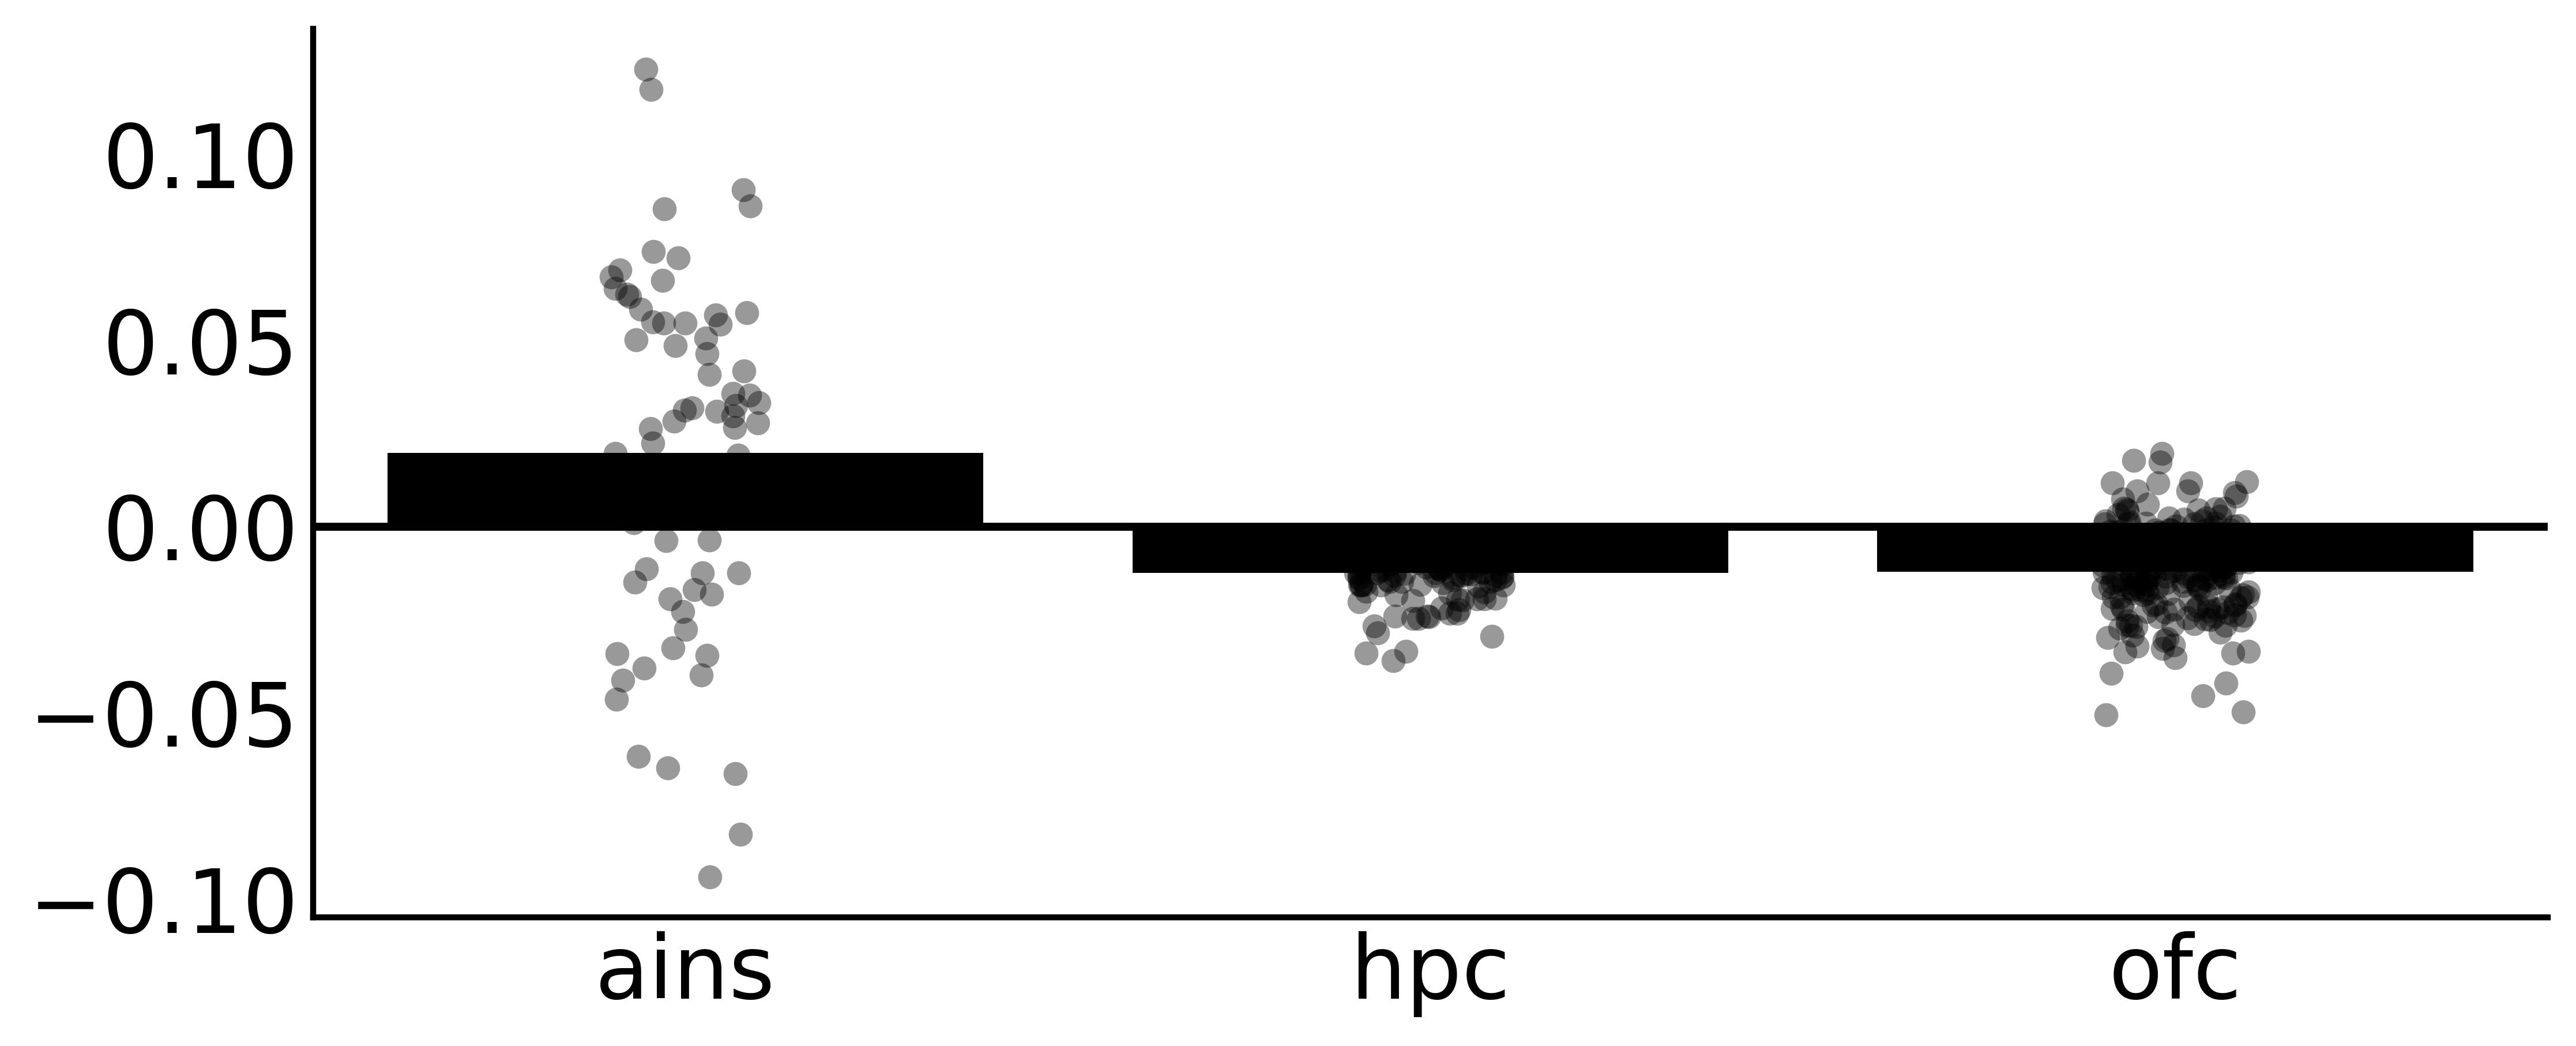

In [31]:
plot_roi_model_results(roi_fit_results,'roi','decisionCPE',bar_order=sig_rois)


#function info - 
# plot_roi_model_results(model_results,x_var,y_var,ylabel=None,color = 'k',bar_order=None,figsize=(10,4),dpi=500,linewidth=1.5,
#                            size=6,sns_context="poster",save_fig=False,save_dir=None,fig_id=None)


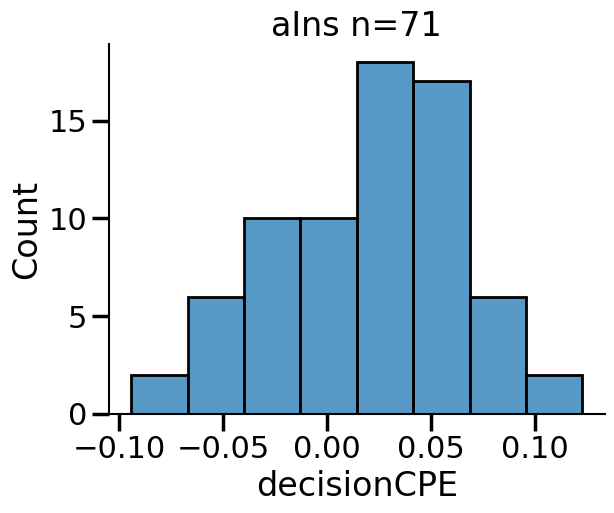

In [32]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'ains'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'ains'].decisionCPE)
plt.title(f'aIns n={n}')

sns.despine()

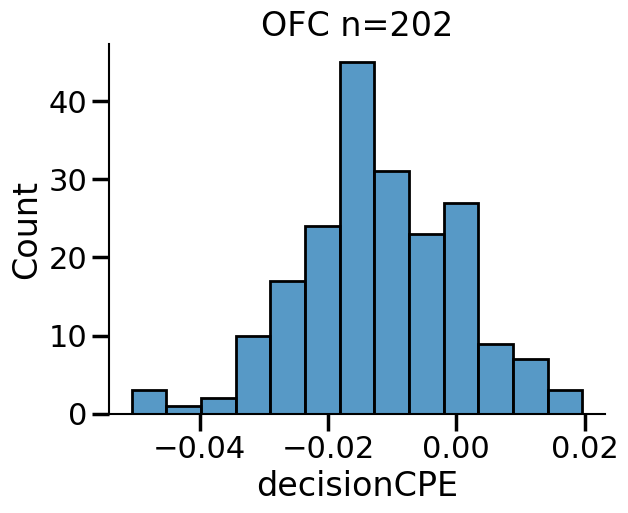

In [33]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'ofc'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'ofc'].decisionCPE)
plt.title(f'OFC n={n}')

sns.despine()

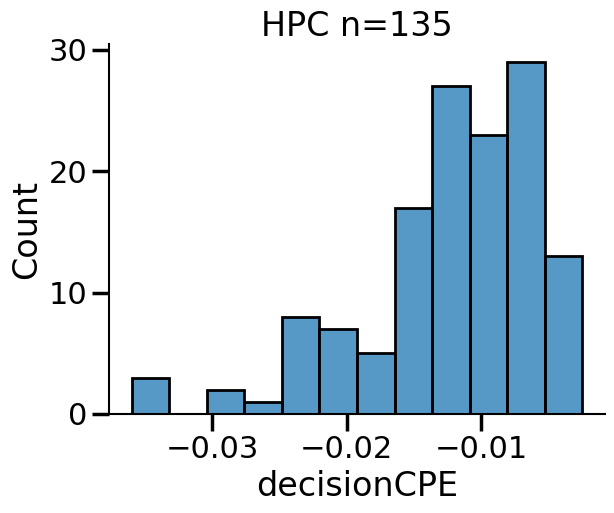

In [34]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'hpc'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'hpc'].decisionCPE)
plt.title(f'HPC n={n}')

sns.despine()

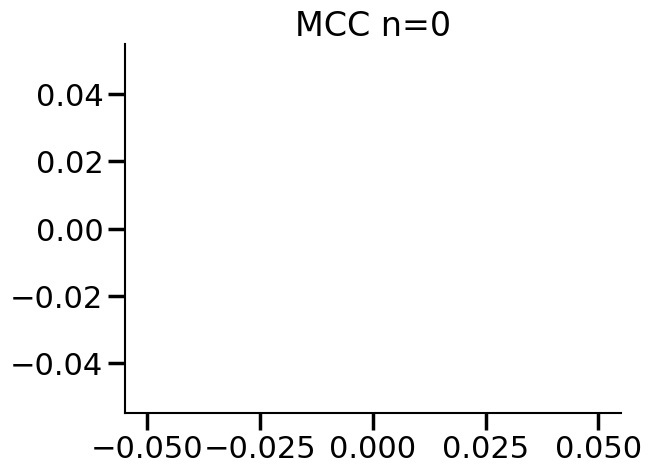

In [35]:
# plot ROI beta distribution
sns.histplot(roi_fit_results[roi_fit_results.roi == 'mcc'].decisionCPE)
n = len(roi_fit_results[roi_fit_results.roi == 'mcc'].decisionCPE)
plt.title(f'MCC n={n}')

sns.despine()

In [36]:
sig_rois

['ains', 'hpc', 'ofc']

In [37]:
# CHECK BDI CORRELATION

rho_data = []
sig_rho = []

# BDI CORRELATIONS
for roi in roi_fit_results.roi.unique().tolist():
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.decisionCPE)
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


acc pearsonr 0.1335073641613426 0.0641709860844414
dmpfc pearsonr 0.4104832086731843 3.4591852231385274e-10
amy pearsonr 0.0821108496366645 0.3872547440587345
sts pearsonr 0.21826194787027609 0.006365822599889517
ains pearsonr -0.14894066014575505 0.21510560874442639
vlpfc pearsonr 0.015642476468833585 0.8890688220089485
hpc pearsonr 0.05166509038550377 0.5517701740321359
mtg pearsonr -0.3367480449060482 0.010426548643500377
ofc pearsonr 0.11170036850242326 0.11349777750772935
pins pearsonr 0.2906069175136679 0.024288567969132813
dlpfc pearsonr 0.4149676211903875 8.824906022596622e-06
smg pearsonr -0.10645633962229577 0.3949070464087331
stg pearsonr 0.2223789794862334 0.02260422013553784
thalamus pearsonr 0.028096778197985194 0.8341657172299289


In [38]:
sig_rho

[('dmpfc', 0.4104832086731843, 3.4591852231385274e-10),
 ('sts', 0.21826194787027609, 0.006365822599889517),
 ('mtg', -0.3367480449060482, 0.010426548643500377),
 ('pins', 0.2906069175136679, 0.024288567969132813),
 ('dlpfc', 0.4149676211903875, 8.824906022596622e-06),
 ('stg', 0.2223789794862334, 0.02260422013553784)]

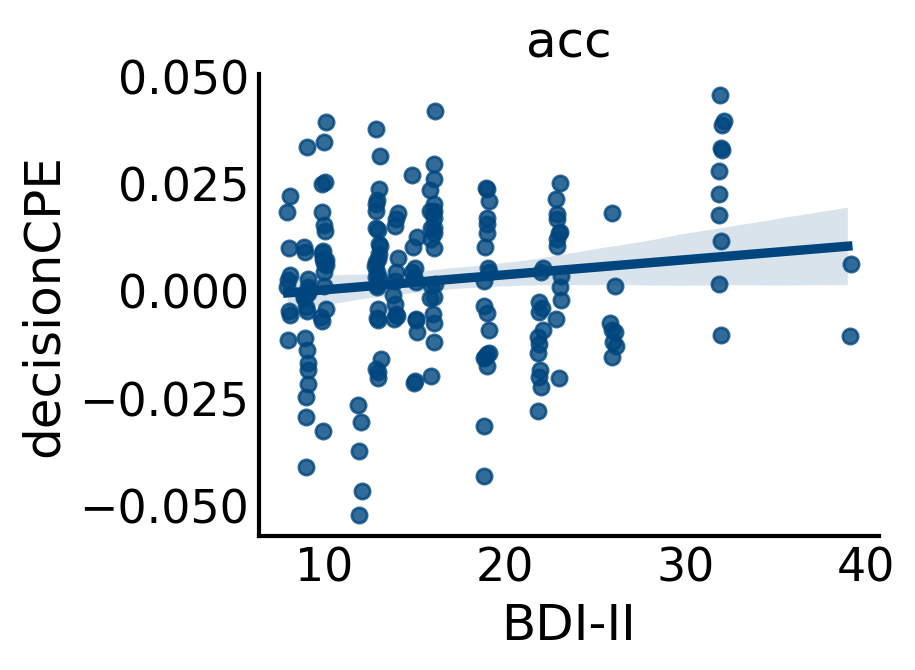

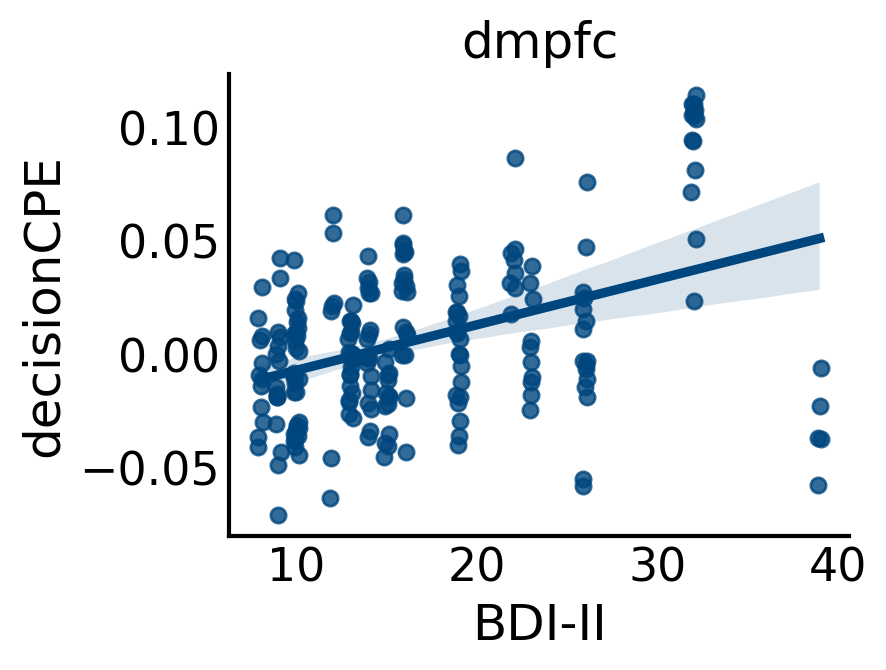

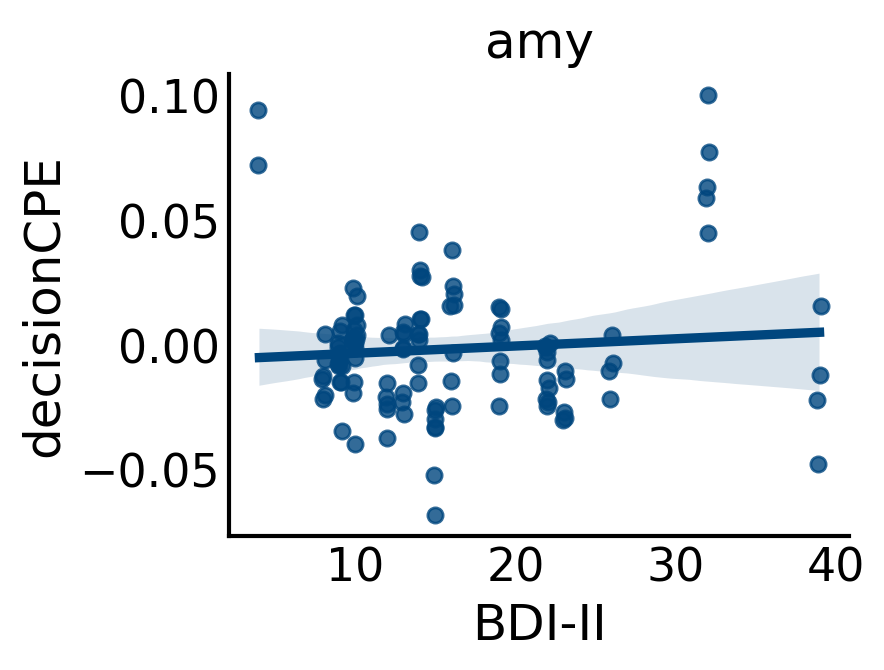

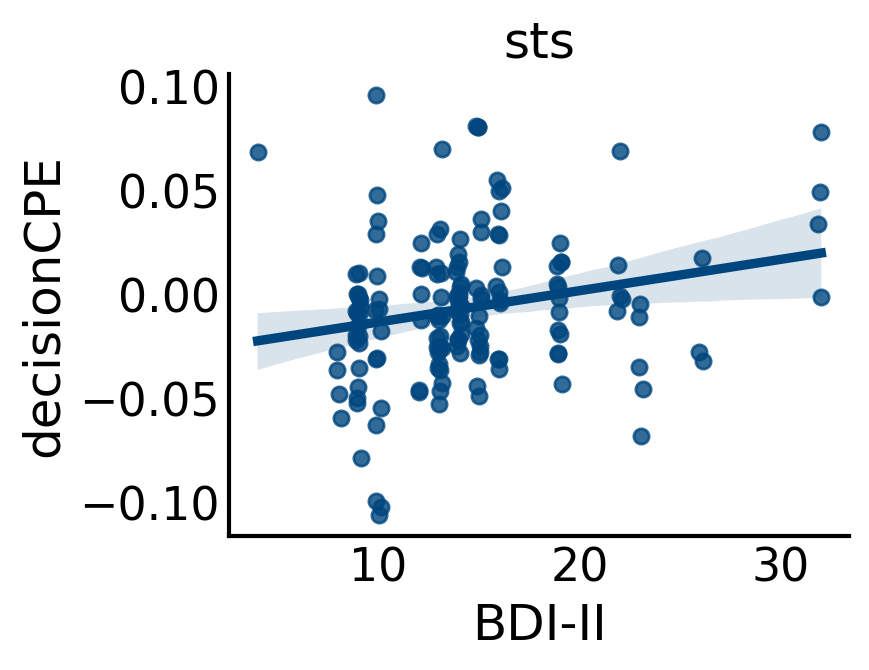

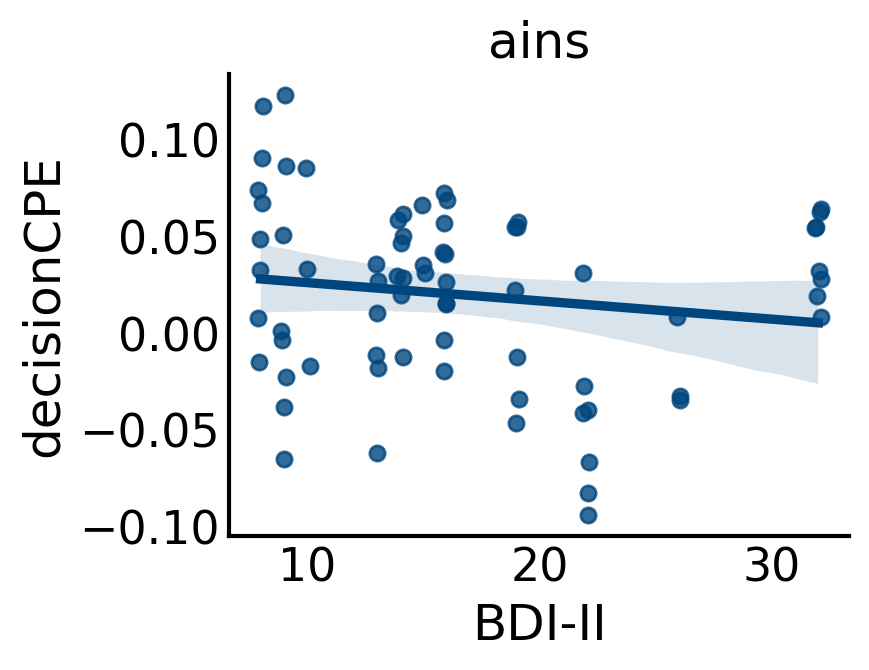

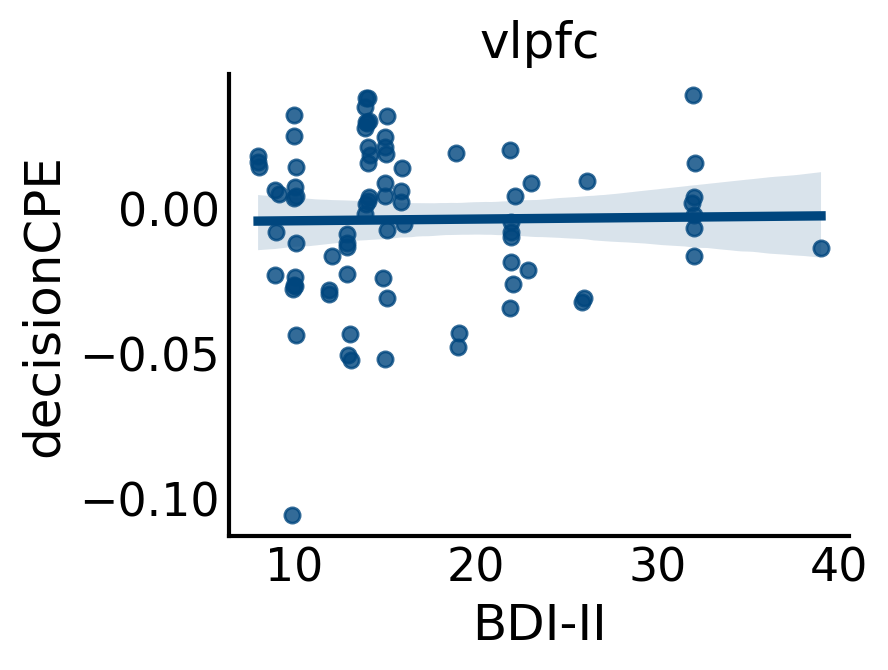

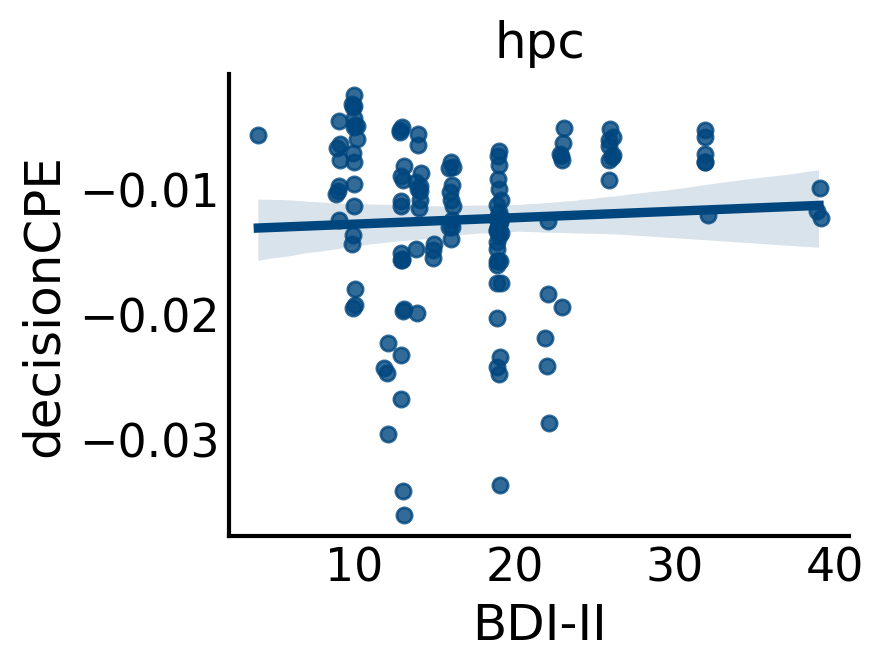

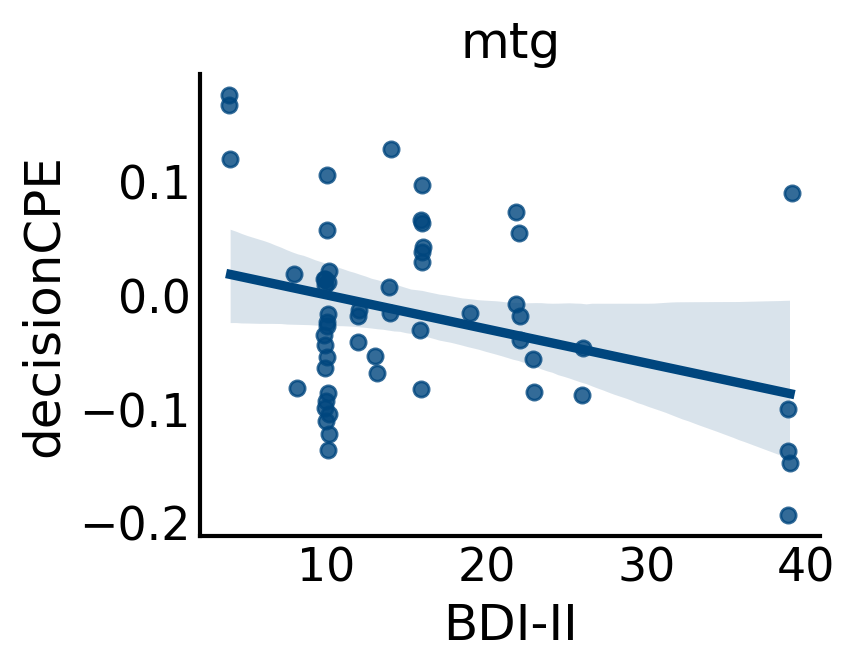

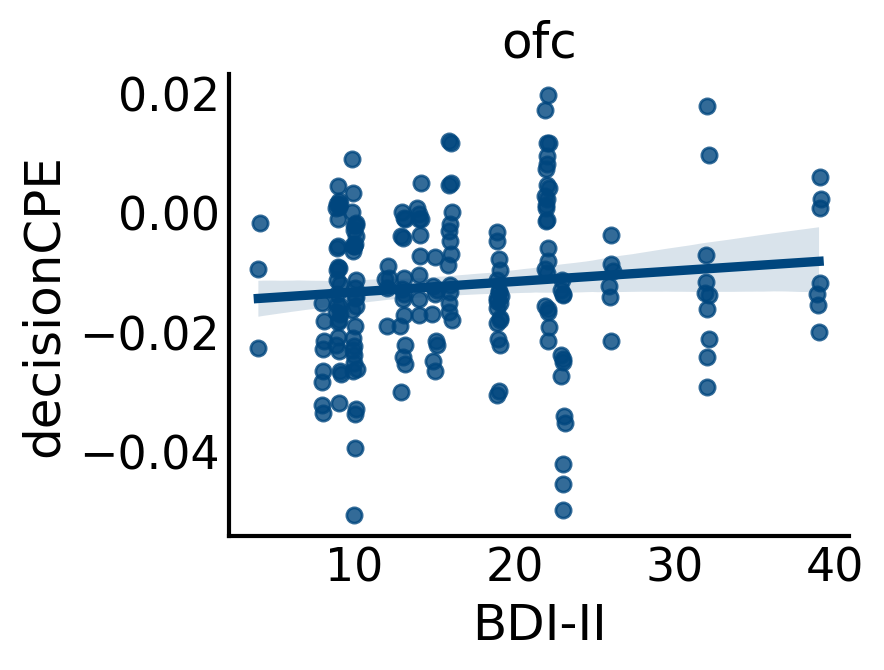

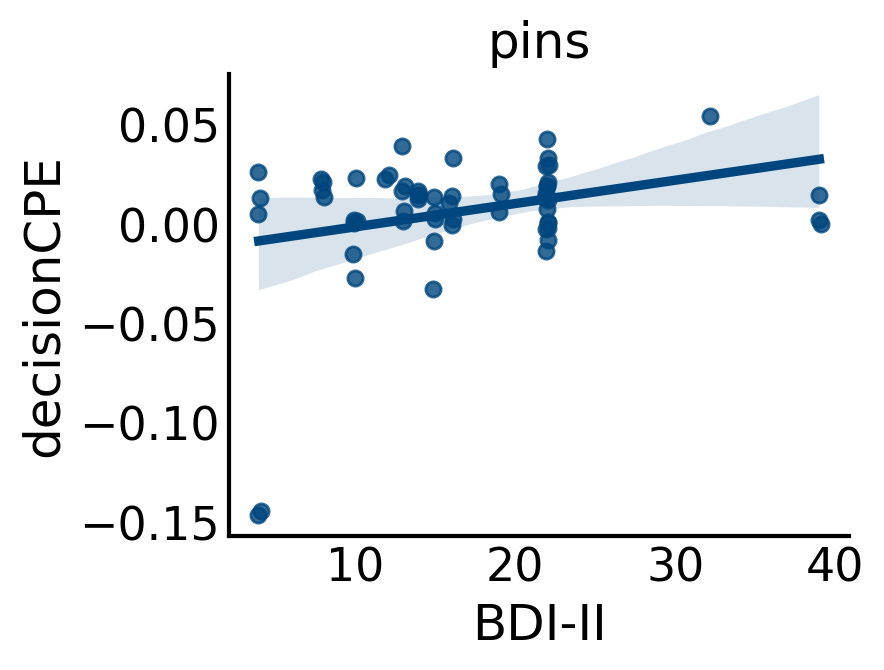

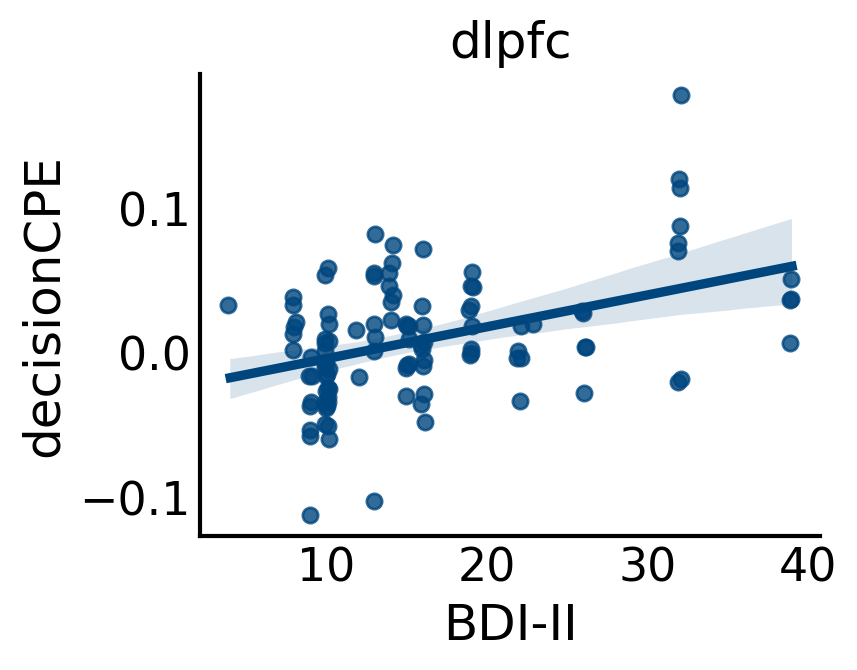

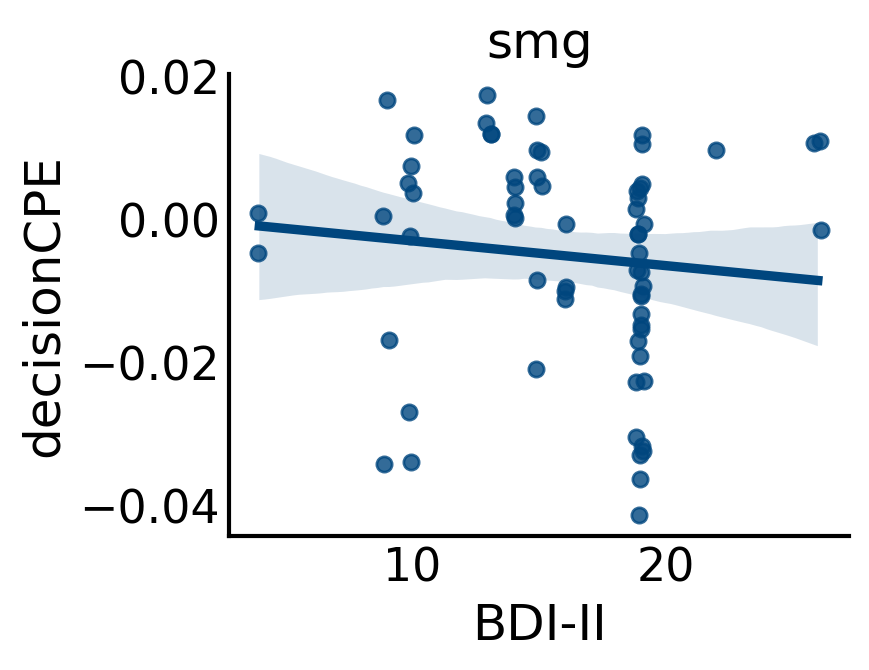

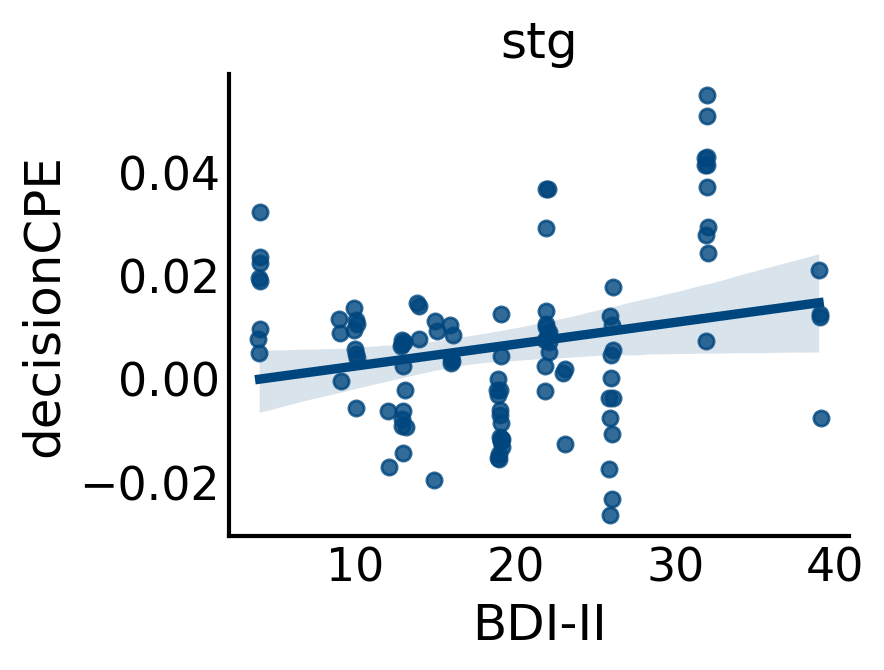

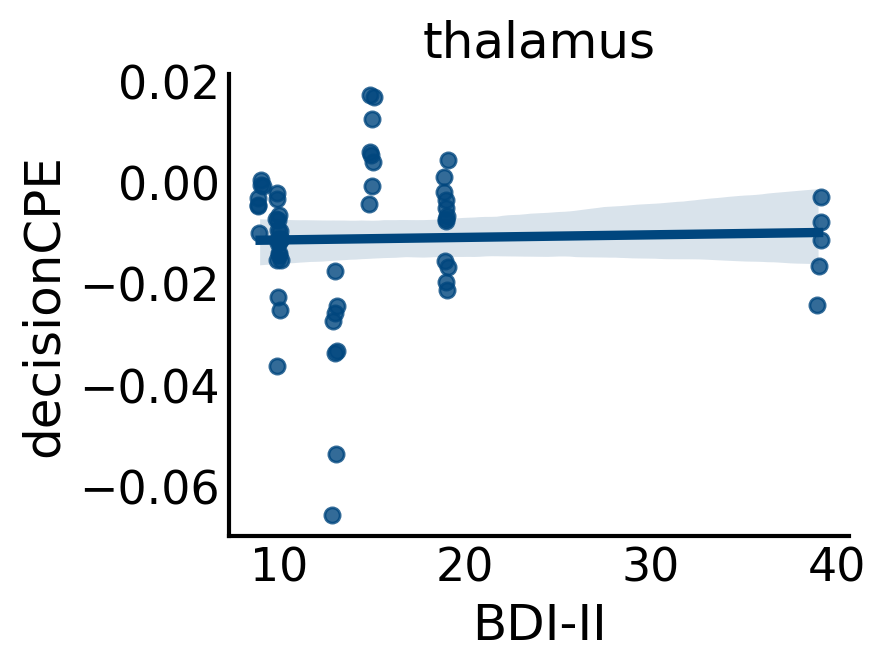

In [39]:

sns.set_context("talk",rc={'axes.linewidth': 1.5})

for roi in roi_fit_results.roi.unique().tolist():
    
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='decisionCPE',scatter=True,ci=95,
                fit_reg=True,color = '#00467e',x_jitter = 0.15,scatter_kws={'s':30}) #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
#     plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
#     plt.ylabel(fr'${band}_{{{zpow}}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}')
    sns.despine()
#     plt.tight_layout()


    
#     sns.despine()
    
# #     plt.savefig(f'{fig_save_dir}/{roi}_{rho}_{rho_p}_roi_bdi_beta-cpe-slope.pdf', format='pdf', metadata=None,
# #         bbox_inches='tight', pad_inches=0.1,dpi=300,
# #         facecolor='auto', edgecolor='auto',
# #         backend=None)
    

# RT ~ CPE:Pow Regressions

In [50]:
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'

In [40]:
rt_vars   = ['decisionCPE','band_pow','decisionCPE:band_pow']
rt_fit = fit_mixed_model(reg_df,rt_vars,outcome_var,rand_eff_var,reml=False)
print(rt_fit.summary())
rt_fit.bic    

LinAlgError: Eigenvalues did not converge


# ROI REGRESSIONS
- test all ROIs & see which ROIs are significant
- correlate bdi with ROI beta coefficients 


In [ ]:
outcome_var  = 'logRT_t1'
rand_eff_var = 'unique_reref_ch'
rt_vars   = ['decisionCPE','band_pow','decisionCPE:band_pow']


In [ ]:
roi_fit_dict = {f'{roi}':fit_mixed_model(reg_df[reg_df.roi==roi],
                                        rt_vars,outcome_var,rand_eff_var,reml=False) 
                for roi in reg_df.roi.unique().tolist()}

roi_fit_results = []

for roi in list(roi_fit_dict.keys()):
    roi_fit = mixed_eff_results_df(roi_fit_dict[roi],reg_df[reg_df.roi==roi])
    roi_fit_results.append(roi_fit)
    
roi_fit_results = pd.concat(roi_fit_results).reset_index(drop=True)


In [ ]:
roi_fit_results['band'] = band
roi_fit_results.to_csv(f'{save_dir}RT_{band}_roi_results.csv')

In [ ]:
roi_fit_results

In [ ]:
raw_roi_stats = {f'{roi}':ttest_1samp(roi_fit_results['decisionCPE:band_pow'][roi_fit_results.roi == roi].unique(),
                 popmean=0) for roi in roi_fit_results.roi.unique().tolist()}
raw_roi_stats

In [ ]:
roi_fit_results

In [ ]:
fe_params_results = {f'{roi}':roi_fit_dict[roi].fe_params for roi in list(roi_fit_dict.keys())}
# fe_params_pvals = {f'{roi}':roi_fit_dict[roi].pvalues for roi in list(roi_fit_dict.keys())}


In [ ]:
fe_results = []
for fe_res in fe_params_results:
    
    fe_results.append(pd.DataFrame({**dict(fe_params_results[fe_res]),**{'roi':fe_res}},index=[0]))


In [ ]:
fe_results = pd.concat(fe_results).reset_index(drop=True)

In [ ]:
fe_results['roi_cpepow_pval'] = [roi_fit_dict[roi].pvalues['decisionCPE:band_pow'] for roi in fe_results.roi.tolist()]


In [ ]:
fe_results

In [ ]:
bonferr_alpha = 0.05/len(fe_results)
bonferr_alpha

In [ ]:
sig_rois = fe_results.roi[fe_results.roi_cpepow_pval <= bonferr_alpha].tolist()
sig_rois

In [65]:
# plot_roi_model_results(roi_fit_results,'roi','decisionCPE:band_pow')


#function info - 
# plot_roi_model_results(model_results,x_var,y_var,ylabel=None,color = 'k',bar_order=None,figsize=(10,4),dpi=500,linewidth=1.5,
#                            size=6,sns_context="poster",save_fig=False,save_dir=None,fig_id=None)


In [ ]:
# # plot ROI beta distribution
# sns.histplot(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
# n = len(roi_fit_results[roi_fit_results.roi == 'acc'].decisionCPE)
# plt.title(f'ACC n={n}')

# sns.despine()

In [ ]:
# CHECK BDI CORRELATION

rho_data = []
sig_rho = []

# BDI CORRELATIONS
for roi in roi_fit_results.roi.unique().tolist():
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]
    rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data['decisionCPE:band_pow'])
#     rho,rho_p     = pearsonr(roi_temp_data.bdi,roi_temp_data.elec_bCPE)
#     print(f'{roi} pearsonr',rho,rho_p)
    rho_data.append(pd.DataFrame({'roi':roi,'rho':rho,'rho_p':rho_p},index=[0]))
#     if rho_p <= bonferr_alpha:
#         sig_bdi_rois.append(roi)
#     if rho_p < bonferr_alpha:
    if rho_p < 0.05:
        sig_rho.append((roi,rho,rho_p))
    print(f'{roi} pearsonr',rho,rho_p)
rho_data = pd.concat(rho_data).reset_index(drop=True)


In [ ]:
sig_rho

In [ ]:

sns.set_context("poster",rc={'axes.linewidth': 1.5})

for roi in roi_fit_results.roi.unique().tolist():
    
    roi_temp_data = roi_fit_results[roi_fit_results.roi==roi]

#     rho   = rho_data[rho_data.roi == roi].round_rho.values[0]
#     rho_p = rho_data[rho_data.roi == roi].round_p.values[0]
    
        
    fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=200)

    sns.regplot(data=roi_temp_data,x='bdi',y='decisionCPE:band_pow',scatter=True,ci=95,
                fit_reg=True,color = '#00467e',x_jitter = 0.15,scatter_kws={'s':15}) #034975
    
#     sns.scatterplot(data = roi_temp_data.groupby(['subj_id']).agg('mean'),x='bdi',
#                     y='decisionCPE',color = '#00467e',edgecolor=None,alpha=0.8)
    
#     plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) 
    plt.xlabel('BDI-II')
#     plt.xlim([0,40])
    
    plt.tick_params(length=0) 
#     plt.ylabel('beta'+r'$beta_{{{zpow}}}$'+' cpe encoding')
#     plt.ylabel(fr'${band}_{{{zpow}}} \sim cpe$')

#     plt.text(np.max(roi_temp_data.bdi)-8,
#              np.round(np.max(roi_temp_data.groupby(['subj_id']).agg('mean').elec_bCPE),3)-0.003,
#              r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',color='k',fontsize=12)
#              color='#00467e',fontsize=16)
#     plt.text(0.8,0.8,r'$rho$ = '+f'{rho} \n'+ fr'$p \approxeq $ {rho_p}',
#             verticalalignment='top', horizontalalignment='right',
#             color='k',fontsize=16)

    plt.title(f'{roi}')
    sns.despine()
#     plt.tight_layout()


    
#     sns.despine()
    
# #     plt.savefig(f'{fig_save_dir}/{roi}_{rho}_{rho_p}_roi_bdi_beta-cpe-slope.pdf', format='pdf', metadata=None,
# #         bbox_inches='tight', pad_inches=0.1,dpi=300,
# #         facecolor='auto', edgecolor='auto',
# #         backend=None)
    